<font size="5">Procesar imagenes ABI y seguir un sistema de nubes en el tiempo. Extraer informaciones globales como Areas de lluvia fuerte y débil</font>

### Tormenta a procesar:
Inicio: 13/03/2023 21 UTC

Fin:    14/03/2023 15 UTC

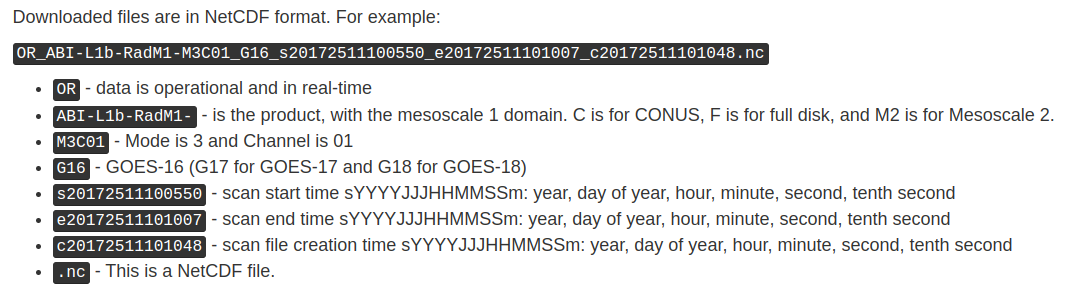

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np

from netCDF4 import Dataset
import cartopy.crs as ccrs  # Plot maps
import os
import sys

from util_imag_2023 import *


# Función de realce lineal al p porciento
def realce(vec, p=2, gamma=1):
    aux = np.sort(vec.flatten())
    imin = int(len(aux) * p / 100)
    imax = int(len(aux) * (100 - p) / 100)
    vmin = float(aux[imin])
    vmax = float(aux[imax])
    rimag = ( (vec - vmin) / (vmax - vmin) )**gamma
    rimag[rimag < 0] = 0
    rimag[rimag > 1] = 1
    return rimag

In [2]:
dir_nc = '/home/msuarez/GOES_16_TF/14032023/CH14/'

Filelist = glob.glob(dir_nc+'*.nc')
Filelist.sort()
Filelist

['/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730030205_e20230730039514_c20230730039563.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730100205_e20230730109514_c20230730109582.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730130205_e20230730139514_c20230730139574.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730200205_e20230730209514_c20230730209575.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730230205_e20230730239514_c20230730239554.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730300205_e20230730309514_c20230730309568.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730330205_e20230730339514_c20230730339573.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14

In [3]:
#img_list_import = [Filelist[5],Filelist[12],Filelist[13],Filelist[16]]

#print('Lista de imagenes a importar:\n')
#for i in range(len(img_list_import)): print(img_list_import[i])

In [4]:
#imagenobj_list = []
#print('Importando imagenes...')
#for i in range(len(img_list_import)): imagenobj_list.append(Dataset(img_list_import[i], 'r'))
#print('Imagenes importadas en la lista imagenobj_list.')

In [5]:
#imagenobj_list[0].variables.keys()

In [3]:
import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')

# Intento primero recortar y despues calibrar las imagenes

In [4]:
imagenobj_list = []
print('Importando imagenes...')
for i in range(len(Filelist)): imagenobj_list.append(Dataset(Filelist[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(Filelist))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte
sup_row = 4000
inf_row = 5000
sup_col = 2500
inf_col = 3600

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 1000  Ancho= 1100
Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tama

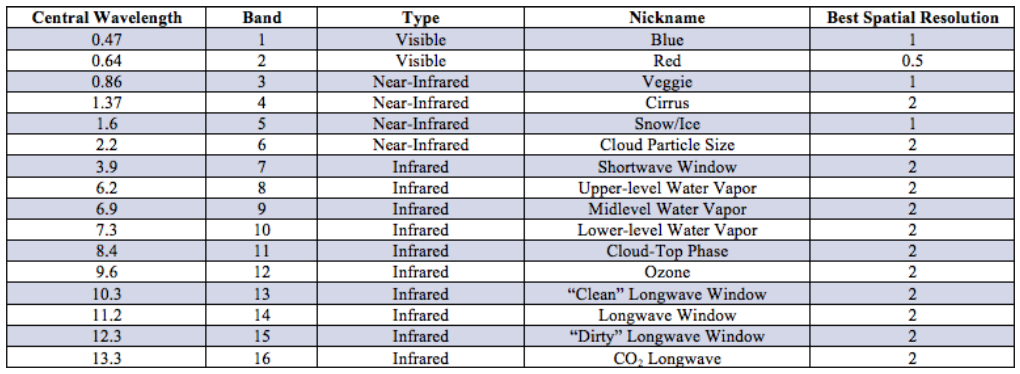

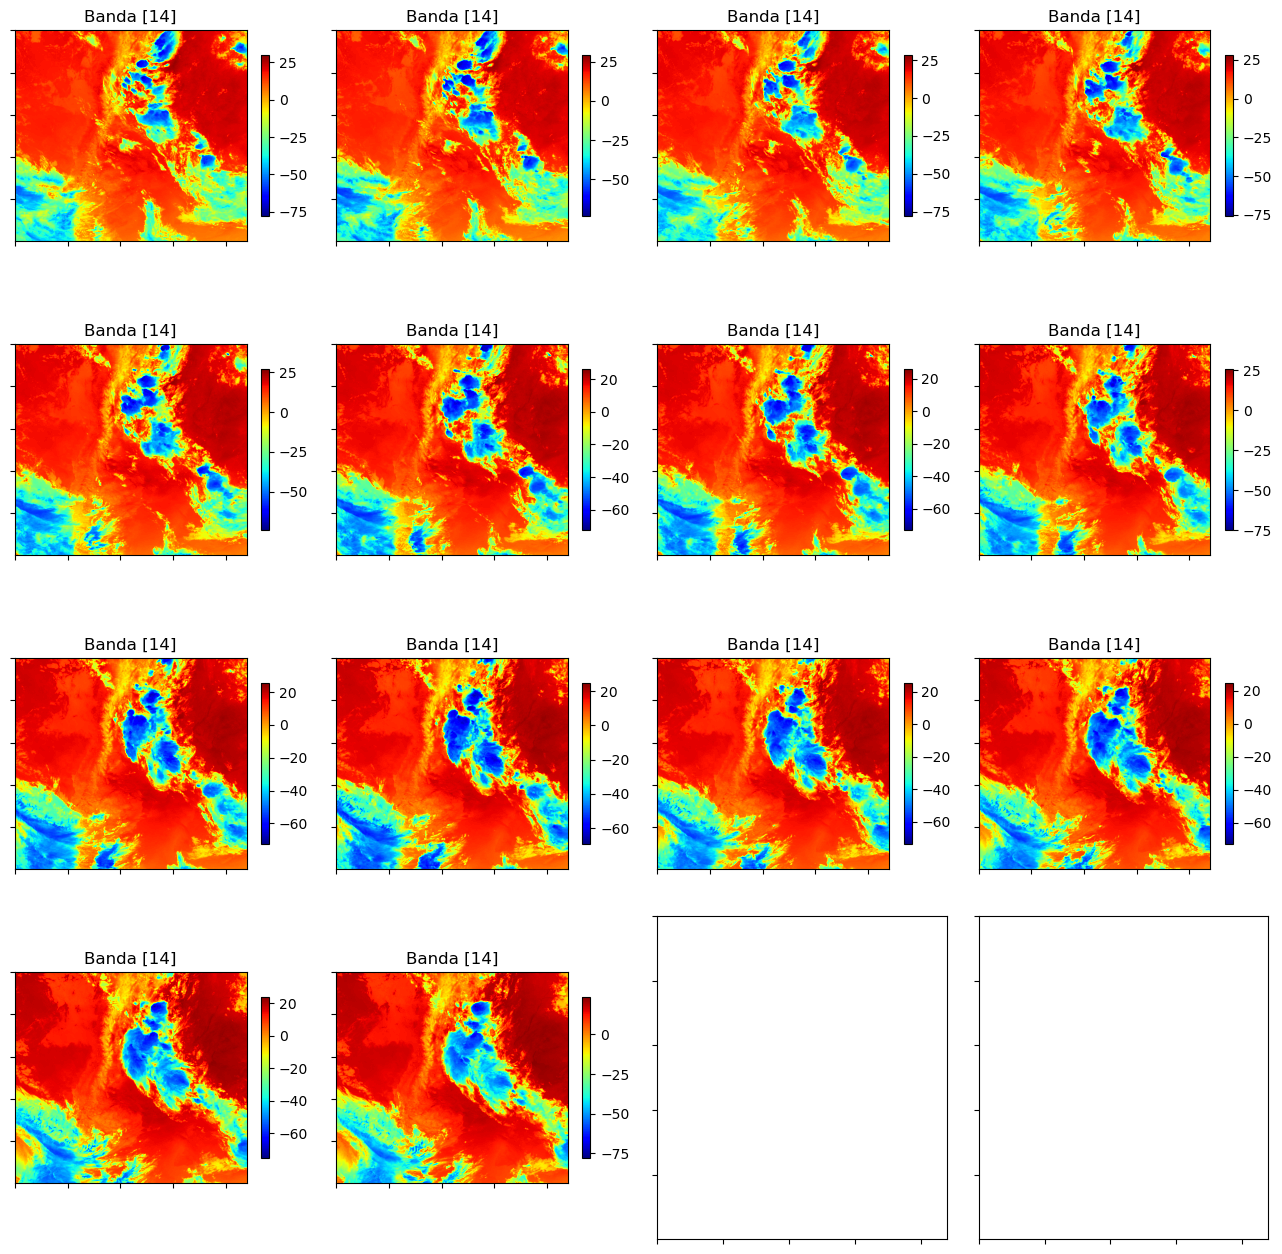

In [5]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(13, 13))
ax = ax.ravel()

for i in range(len(imag_cal_list)):
    im = ax[i].imshow(imag_cal_list[i], cmap='jet')
    ax[i].set_title('Banda '+str(metadato_list[i]['band_id'][:]))
    ax[i].set_xticklabels('')
    ax[i].set_yticklabels('')
    fig.colorbar(im, shrink=.5, ax=ax[i])
    
plt.tight_layout()
plt.show()

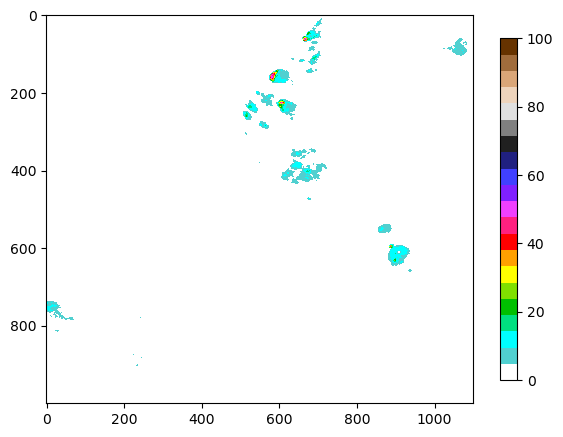

In [13]:
qpe_obj = Dataset('/home/msuarez/GOES_16_TF/14032023/QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730000205_e20230730009513_c20230730010027.nc', 'r')
 
plt.figure(figsize=(6, 6))

plt.subplot(111)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, vmin=0, vmax=100)
plt.colorbar(shrink=.6)

plt.tight_layout()
plt.show()

In [46]:
path = '/home/msuarez/GOES_16_TF/14032023/'

list_imgs = ['CH08/OR_ABI-L1b-RadF-M6C08_G16_s20230730000205_e20230730009513_c20230730009575.nc',
             'CH09/OR_ABI-L1b-RadF-M6C09_G16_s20230730000205_e20230730009519_c20230730009581.nc',
             'CH10/OR_ABI-L1b-RadF-M6C10_G16_s20230730000205_e20230730009525_c20230730009554.nc',
             'CH11/OR_ABI-L1b-RadF-M6C11_G16_s20230730000205_e20230730009514_c20230730009568.nc',
             'CH12/OR_ABI-L1b-RadF-M6C12_G16_s20230730000205_e20230730009519_c20230730009573.nc',
             'CH13/OR_ABI-L1b-RadF-M6C13_G16_s20230730000205_e20230730009525_c20230730009576.nc',
             'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc',
             'CH15/OR_ABI-L1b-RadF-M6C15_G16_s20230730000205_e20230730009523_c20230730009571.nc',
             'CH16/OR_ABI-L1b-RadF-M6C16_G16_s20230730000205_e20230730009529_c20230730009560.nc']

QPE_img = 'QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730000205_e20230730009513_c20230730010027.nc'

imagenobj_list = []

print('Importando imagenes...')
for i in range(len(list_imgs)): imagenobj_list.append(Dataset(path+list_imgs[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(list_imgs))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte
sup_row = 4000
inf_row = 5000
sup_col = 2500
inf_col = 3600

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 1000  Ancho= 1100
Procesando Canal 8
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 9
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 10
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 11
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 12
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 13
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 15
Tamaño

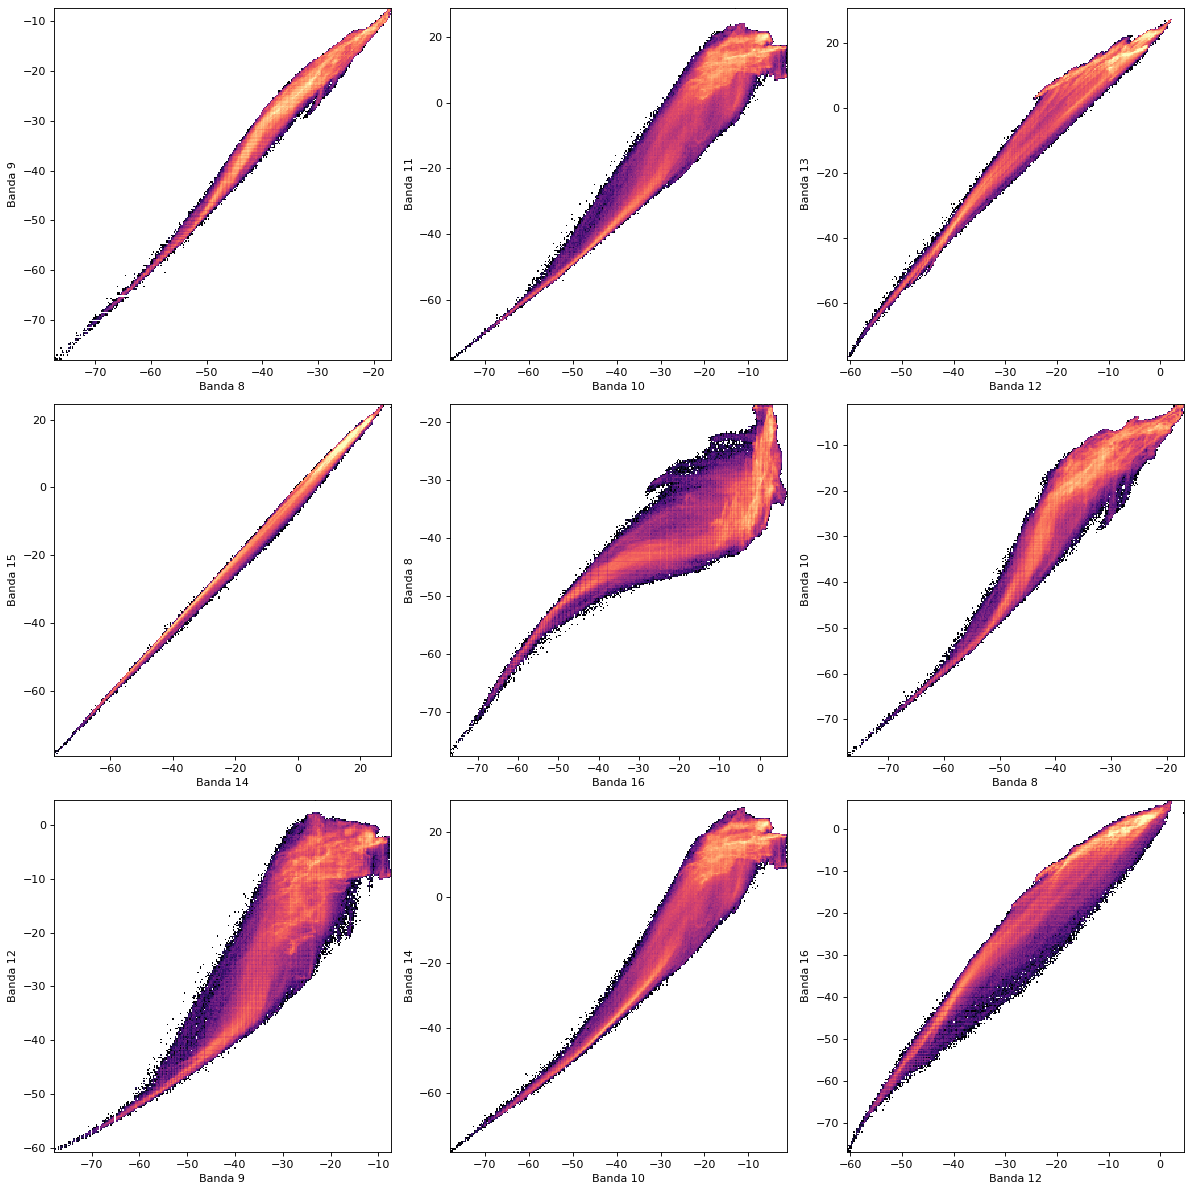

In [17]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
norm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda 8')
plt.ylabel('Banda 9')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(imag_cal_list[2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[3].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda 10')
plt.ylabel('Banda 11')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(imag_cal_list[4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[5].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 12')
plt.ylabel('Banda 13')

plt.subplot(3, 3, 4)

plt.hist2d(imag_cal_list[6].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[7].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 14')
plt.ylabel('Banda 15')


plt.subplot(3, 3, 5)

plt.hist2d(imag_cal_list[8].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[0].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 16')
plt.ylabel('Banda 8')


plt.subplot(3, 3, 6)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 8')
plt.ylabel('Banda 10')


plt.subplot(3, 3, 7)

plt.hist2d(imag_cal_list[1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[4].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 9')
plt.ylabel('Banda 12')


plt.subplot(3, 3, 8)

plt.hist2d(imag_cal_list[2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[6].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 10')
plt.ylabel('Banda 14')


plt.subplot(3, 3, 9)

plt.hist2d(imag_cal_list[4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[8].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 12')
plt.ylabel('Banda 16')


plt.tight_layout()
plt.show()

In [18]:
def pca(X):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].
    eigen_vals : numpy.array
        Array con los eigen values. 
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca, eigen_vals, eigen_vecs

In [47]:
qpe_obj = Dataset(path+QPE_img, 'r')

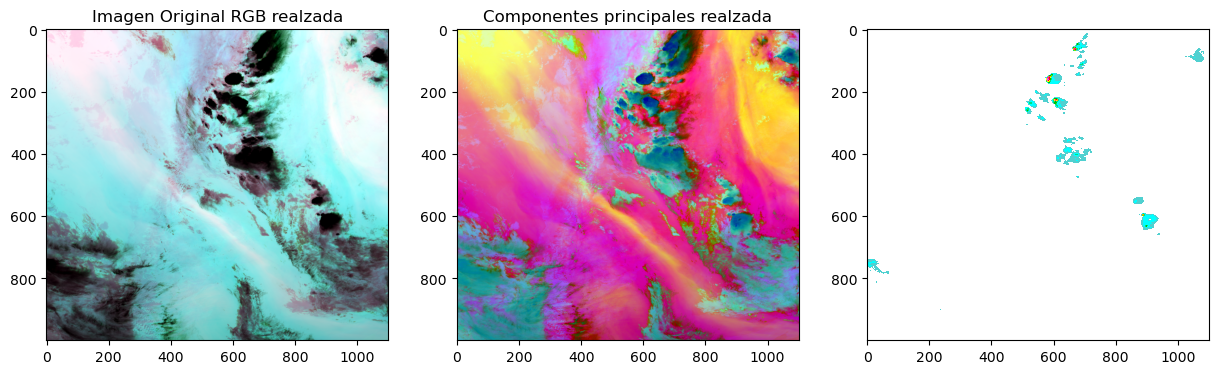

In [54]:
RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

RGBrec[:, :, 0] = imag_cal_list[0]
RGBrec[:, :, 1] = imag_cal_list[3]
RGBrec[:, :, 2] = imag_cal_list[8]

# Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

# Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
# NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
#       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
#       dimensiones adecuadas para aplicar la función.
# x_pca_3d = np.reshape(x_pca, [..., ..., ...])
x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, 3])

# Aplique un realce a x_pca_3d
x_pca_3d_realzada = np.zeros_like(x_pca_3d)
for i in range(3):
    x_pca_3d_realzada[:, :, i] = realce(x_pca_3d[:, :, i])
    
# Aplique un realce a x_pca_3d
RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))
for j in range(3):
    RGBrec_realzada[:,:,j] = realce(RGBrec[:,:,j])

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(RGBrec_realzada)
plt.title("Imagen Original RGB realzada")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada)
plt.title('Componentes principales realzada')

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, vmin=0, vmax=100)
# plt.colorbar(shrink=.2)

plt.show()